# Hyperplanes for Analysis B

This code shows an example of how to produce an expected number of events for the histograms used in the analysis given the dataset of Analysis B from https://icecube.wisc.edu/science/data/highstats_nuosc_3y. This calculation will not return the values from the paper because we do not use a realistic neutrino flux model and it misses oscillations.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load the data files
neutrino_mc = pd.read_csv("/home/peller/datarelease/dragon/neutrino_mc.csv")
muons = pd.read_csv("/home/peller/datarelease/dragon/muons.csv")

hyperplanes = {}
hyperplanes['nuall_nc'] = pd.read_csv("/home/peller/datarelease/dragon/hyperplanes_all_nc.csv")
hyperplanes['nue_cc'] = pd.read_csv("/home/peller/datarelease/dragon/hyperplanes_nue_cc.csv")
hyperplanes['numu_cc'] = pd.read_csv("/home/peller/datarelease/dragon/hyperplanes_numu_cc.csv")
hyperplanes['nutau_cc'] = pd.read_csv("/home/peller/datarelease/dragon/hyperplanes_nutau_cc.csv")

In [3]:
# add some simple weights
# This is a dummy flux model that is used soleley for illustration purposes
# the weights here also do not include the oscilaltion calculations which are necessary
neutrino_mc['plot_weight'] = neutrino_mc['weight'] * 1e10 * neutrino_mc['true_energy'] ** -3  / (1 + abs(neutrino_mc['true_coszen']))
muons['plot_weight'] = muons['count']

In [4]:
# split up by flavour and interaction type
neutrinos = {}
neutrinos['nuall_nc'] = neutrino_mc[neutrino_mc['type'] == 0]
neutrinos['nue_cc'] = neutrino_mc[(neutrino_mc['type'] > 0) & (abs(neutrino_mc['pdg']) == 12)]
neutrinos['numu_cc'] = neutrino_mc[(neutrino_mc['type'] > 0) & (abs(neutrino_mc['pdg']) == 14)]
neutrinos['nutau_cc'] = neutrino_mc[(neutrino_mc['type'] > 0) & (abs(neutrino_mc['pdg']) == 16)]

In [5]:
# binning definition from readme file
reco_energy_bins = [5.623413,  7.498942, 10. , 13.335215, 17.782795, 23.713737, 31.622776, 42.16965 , 56.23413]
reco_coszen_bins = [-1., -0.75, -0.5 , -0.25,  0., 0.25, 0.5, 0.75, 1.]

In [6]:
# bestfit point of detector systematics from Phys. Rev. D 99, 032007 (2019), Table 2
bestfit = {}
bestfit['ice_scattering'] = 0.974
bestfit['ice_absorption'] = 1.021
bestfit['opt_eff_overall'] = 1.05
bestfit['opt_eff_lateral'] = -0.25
bestfit['opt_eff_headon'] = -1.15

In [7]:
# calculate the correction factors from detector systematics at bestfit point
for hyperplane in hyperplanes.values():
    hyperplane['correction_factor'] = (
        hyperplane['offset'] +
        hyperplane['ice_absorption'] * (bestfit['ice_absorption'] - 1.) * 100. +
        hyperplane['ice_scattering'] * (bestfit['ice_scattering'] - 1.) * 100. +
        hyperplane['opt_eff_overall'] * (bestfit['opt_eff_overall']) +
        hyperplane['opt_eff_lateral'] * ((bestfit['opt_eff_lateral'] * 10) + 25) +
        hyperplane['opt_eff_headon'] * (bestfit['opt_eff_headon'])
        )

In [8]:
def get_hist(df, weight):
    '''retrieve histogram in (energy x coszen) space'''
    hist, _, _ = np.histogram2d(df['reco_energy'], df['reco_coszen'], bins=(reco_energy_bins, reco_coszen_bins), weights=df[weight])
    return hist

In [9]:
def plot(hist, ax):
    '''plot a 2d map'''
    pc = ax.pcolormesh(reco_energy_bins, reco_coszen_bins, hist.T)
    plt.gcf().colorbar(pc, ax=ax)
    ax.set_xscale('log')
    ax.set_xlabel('Energy (GeV)')
    ax.set_ylabel(r'$\cos{\vartheta}$')

In [10]:
# example of nue CC events in the cascade category
raw = get_hist(neutrinos['nue_cc'][neutrinos['nue_cc']['pid'] == 0], weight='plot_weight')
correction = get_hist(hyperplanes['nue_cc'][hyperplanes['nue_cc']['pid'] == 0], weight='correction_factor')

Text(0.5,1,'corrected')

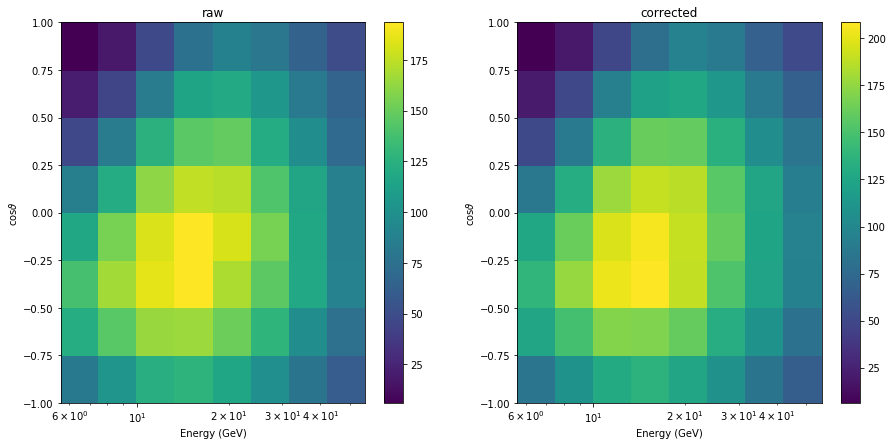

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plot(raw, ax[0])
plot(raw * correction, ax[1])

ax[0].set_title('raw')
ax[1].set_title('corrected')

In [12]:
# let's look at the total expectation
cascades = []
tracks = []

In [13]:
for key in neutrinos.keys():
    raw = get_hist(neutrinos[key][neutrinos[key]['pid'] == 0], weight='plot_weight')
    correction = get_hist(hyperplanes[key][hyperplanes[key]['pid'] == 0], weight='correction_factor')
    cascades.append(raw * correction)
    
    raw = get_hist(neutrinos[key][neutrinos[key]['pid'] == 1], weight='plot_weight')
    correction = get_hist(hyperplanes[key][hyperplanes[key]['pid'] == 1], weight='correction_factor')
    tracks.append(raw * correction)    

In [14]:
# add in muons
cascades.append(get_hist(muons[muons['pid'] == 0], weight='plot_weight'))
tracks.append(get_hist(muons[muons['pid'] == 1], weight='plot_weight'))

Text(0.5,1,'Track-like')

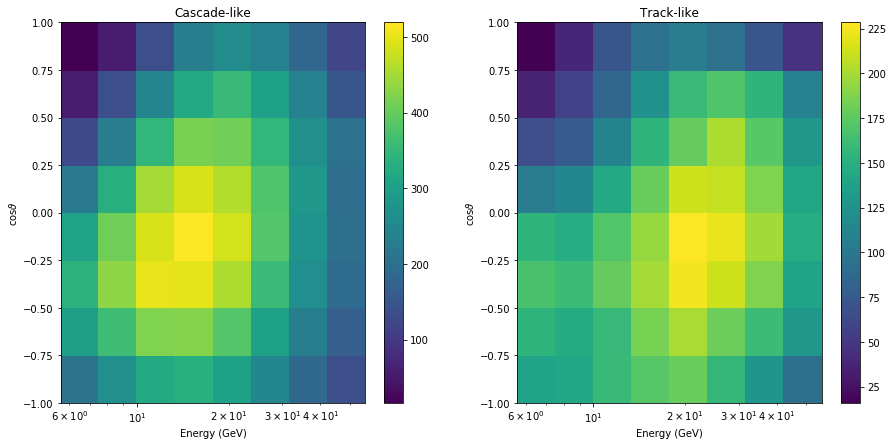

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plot(sum(cascades), ax[0])
plot(sum(tracks), ax[1])
ax[0].set_title('Cascade-like')
ax[1].set_title('Track-like')